# Explore ECG dataset
Stefan/Yuzhao Heng
Since Sun. Oct. 31st, 2021


Check out data format of publicly available datasets & determine which to use.

e.g. If they contain 12-lead recordings, is each beat labeled


## Setup



In [1]:
import os

import wfdb
from wfdb import processing
from icecream import ic


from util import *


os.chdir('../../datasets')
!ls
dsets = list(config('datasets').keys())
ic(dsets)



KIT-20-PVC           PSTOV                St-Petersburg-INCART
MIT-BIH-MVED         PTB-XL


ic| dsets: ['BIH_MVED', 'INCART', 'PTB_XL']


['BIH_MVED', 'INCART', 'PTB_XL']

## INCART
St Petersburg INCART 12-lead Arrhythmia Database


### Is the R-peak accurate, i.e. local maxima/minima?



ic| dset['nm']: 'St Petersburg INCART 12-lead Arrhythmia Database'
ic| rec.p_signal.shape: (462600, 12)
ic| rec.fs: 257


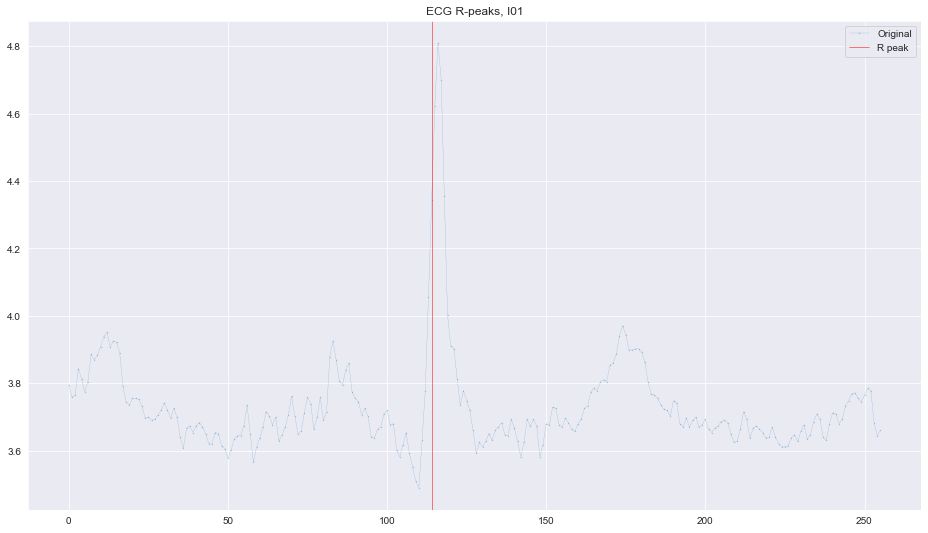

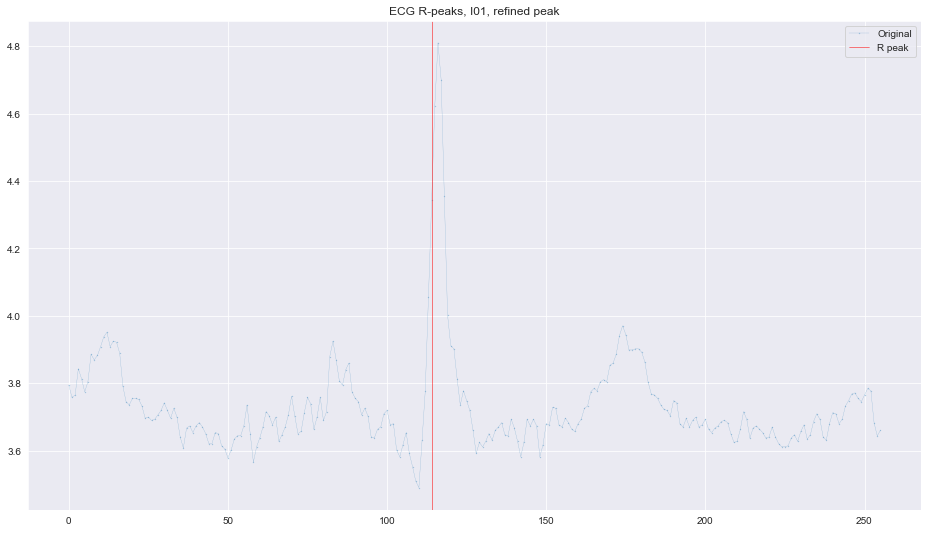

In [8]:
dset = config(f'datasets.{dsets[1]}')
ic(dset['nm'])
rnm = 'I01'
fnm = f'{dset["dir_nm"]}/{rnm}'
rec = wfdb.rdrecord(fnm)
ic(rec.p_signal.shape)
ic(rec.fs)

sampto = 2 ** 8
rec = wfdb.rdrecord(fnm, sampto=sampto)
ann = wfdb.rdann(fnm, extension='atr', sampto=sampto)

sig = rec.p_signal[:, 0]
idxs_rpeak = ann.sample
plot_rpeak(sig, idxs_rpeak, title=rnm)
idxs_rpeak = refine_rpeak(sig, idxs_rpeak, fqs=rec.fs)
plot_rpeak(sig, idxs_rpeak, title=f'{rnm}, refined peak')

## KIT-20-PVC
Human PVC and Paced beats (KIT-20-PVC_Clinical_1906-10-30)

BSPM data, not ECG


In [3]:
from scipy.io import loadmat


# fnm = 'KIT-20-PVC/Interventions/InterventionPace1/Subject20_run01.mat'
# mat = loadmat(fnm)
# ic(mat)

fnm = 'KIT-20-PVC/Interventions/PVC/Subject20_run01.mat'
mat = loadmat(fnm)
data = mat['bspm']
ic(type(data), data.shape)

data = data[0][0]
ic(type(data), len(data))

data, unit, beat_type, file_nm = data
ic(data, unit, beat_type, file_nm)
ic(type(data), data.shape)



ic| type(data): <class 'numpy.ndarray'>, data.shape: (1, 1)
ic| type(data): <class 'numpy.void'>, len(data): 4
ic| data: array([[ 0.        , -0.00313843, -0.0030269 , ..., -0.03043172,
                  -0.03204859, -0.02841264],
                 [ 0.        , -0.00255374, -0.00326898, ...,  0.03951429,
                   0.03700217,  0.03904396],
                 [ 0.        ,  0.00011707,  0.00174486, ...,  0.03171732,
                   0.03228344,  0.03745946],
                 ...,
                 [ 0.        ,  0.0028107 ,  0.0032005 , ...,  0.01739727,
                   0.02797695,  0.03283168],
                 [ 0.        ,  0.00250143,  0.00237055, ...,  0.04354762,
                   0.04959223,  0.05541237],
                 [ 0.        ,  0.0039265 ,  0.00644877, ...,  0.05749454,
                   0.06818049,  0.07494887]])
    unit: array(['mV'], dtype='<U2')
    beat_type: array(['PVC'], dtype='<U3')
    file_nm: array(['Subject20_run01.mat'], dtype='<U19')
ic| type

(numpy.ndarray, (63, 180))

## PSTOV
[Multiple Ventricle Pacing Sites Pat#3 (Charles_PSTOV-12-07-29)](https://edgar.sci.utah.edu/human-pacing-site/11-charles_pstov-12-07-29.html)

Seems to only contain the QRS complex


ic| mat: {'__globals__': [],
          '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Oct 1'
                        b'6 14:36:16 2015',
          '__version__': '1.0',
          'bspm': array([[(array([[ 0.      ,  0.022696,  0.032321, ...,  0.042838,  0.018738,
                  0.010643],
                [ 0.      ,  0.020598,  0.030319, ...,  0.009359, -0.012449,
                 -0.022405],
                [ 0.      ,  0.017847,  0.025191, ..., -0.009756, -0.033478,
                 -0.042839],
                ...,
                [ 0.      ,  0.003845,  0.008847, ...,  0.009791, -0.005612,
                 -0.009291],
                [ 0.      ,  0.006458,  0.012307, ...,  0.003302, -0.014493,
                 -0.018685],
                [ 0.      ,  0.007566,  0.012633, ..., -0.032618, -0.047524,
                 -0.053156]]), array(['mV'], dtype='<U2'), array(['BSPM from pacing localization on subject3 from the pstov dataset. Ventricle LV, location ID: 1

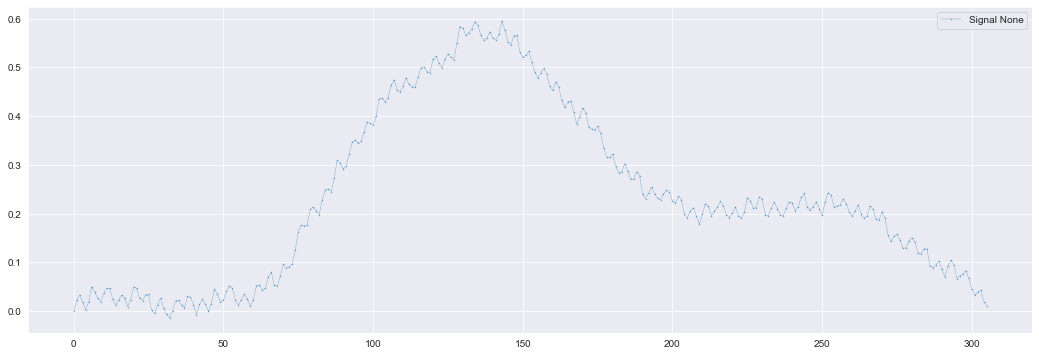

In [4]:
fnm = 'PSTOV/Interventions/interventionLeftVentPace01/2012-07-29Subject_run1'
mat = loadmat(fnm)
ic(mat)
data = mat['bspm']
ic(type(data), data.shape)

data = data[0][0]
ic(type(data), len(data))

data, unit, description = data
ic(data, unit, description)
ic(type(data), data.shape)

plot_single(data[0])



## PTB-XL
Looks like I need to detect R peaks myself



ic| dset['nm']: 'PTB-XL, a large publicly available electrocardiography dataset'
ic| rec.p_signal.shape: (256, 12)


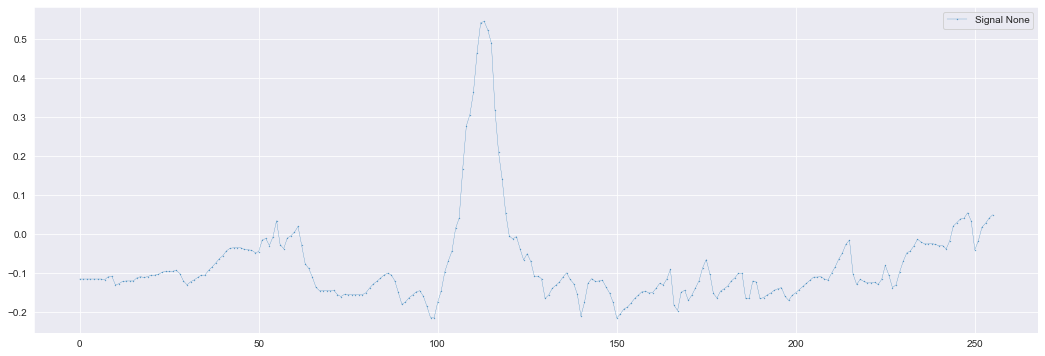

ic| hard_peaks.shape: (566,)
    hard_peaks[:20]: array([ 7,  9, 10, 17, 18, 27, 30, 49, 52, 53, 55, 57, 61, 71, 73, 74, 86,
                            90, 95, 99])
ic| soft_peaks.shape: (53,)
    soft_peaks[:20]: array([ 44,  68,  77, 184, 220, 236, 271, 278, 397, 419, 430, 444, 460,
                            467, 514, 620, 625, 719, 767, 772])


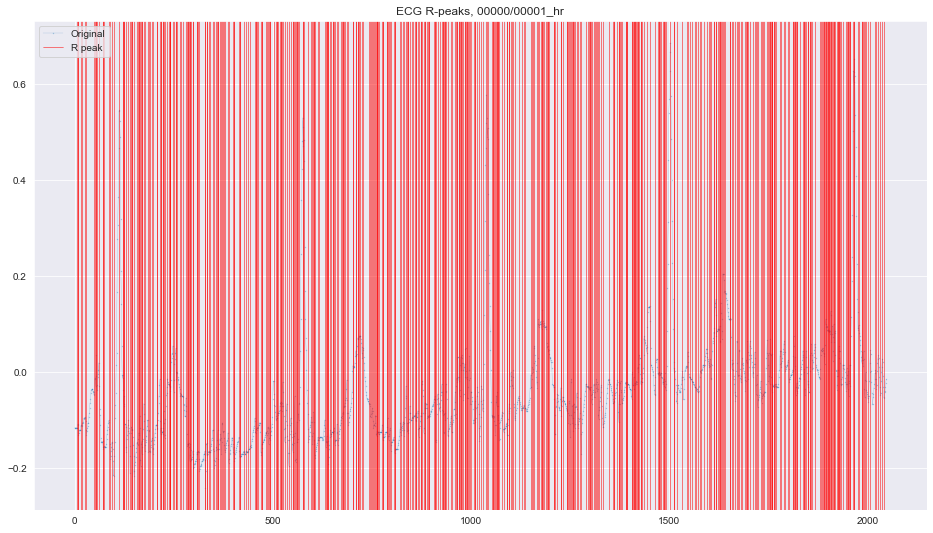

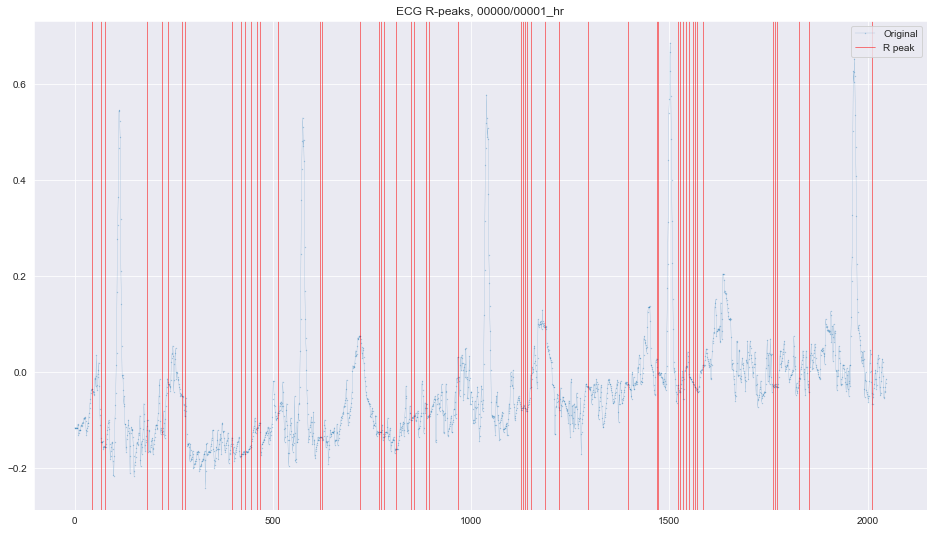

In [6]:
dset = config(f'datasets.{dsets[2]}')
ic(dset['nm'])

rnm = '00000/00001_hr'
fnm = f'{dset["dir_nm"]}/{rnm}'

sampto = 2 ** 8
rec = wfdb.rdrecord(fnm, sampto=sampto)
ic(rec.p_signal.shape)
sig = rec.p_signal[:, 0]
plot_single(sig)


sampto = 2 ** 11
rec = wfdb.rdrecord(fnm, sampto=sampto)
sig = rec.p_signal[:, 0]

hard_peaks, soft_peaks = wfdb.processing.find_peaks(sig)
ic(hard_peaks.shape, hard_peaks[:20])  # Doesn't look good
ic(soft_peaks.shape, soft_peaks[:20])
plot_rpeak(sig, hard_peaks, title=rnm)
plot_rpeak(sig, soft_peaks, title=rnm)

